In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import time
import tqdm

import os
import sys
# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.normalization import normalize_range, un_normalize_range
from utils.colormaps import b_viridis, b_winter

from dataset import DatasetMRF
from model import Network

import numpy as np
import pypulseq
import scipy.io as sio

from cest_mrf.write_scenario import write_yaml_dict
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.dot_product import  dot_prod_matching

from configs import ConfigPreclinical
import random

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(2024)

# Specify data and output folder

In [3]:
data_f = 'data'
output_f = 'results'

In [4]:
# Use GPU if available (otherwise use CPU)
if torch.cuda.is_available():
    device = 'cuda'
    print("GPU found and will be used")
else:
    device = 'cpu'
    print("GPU was not found. Using CPU")

GPU found and will be used


# Generate training dictionary

In [27]:
cfg = ConfigPreclinical().get_config()

# Define output filenames
yaml_fn = cfg['yaml_fn']
seq_fn = cfg['seq_fn'] # we using the same sequence from the dot-product example, so it just provided here, you can refer to the dot-product example for more details
dict_fn = cfg['dict_fn']

# Write the .yaml according to the config.py file (inside cest_mrf folder)
write_yaml_dict(cfg, yaml_fn)

start = time.perf_counter()
dictionary = generate_mrf_cest_dictionary(seq_fn=seq_fn, param_fn=yaml_fn, dict_fn=dict_fn, num_workers=cfg['num_workers'],
                                axes='xy')  # axes can also be 'z' if no readout is simulated
end = time.perf_counter()
s = (end - start)
print(f"Dictionary simulation and preparation took {s:.03f} s.")


No MT pools found in param files! specify with "mt_pool"
Found 665873 different parameter combinations.
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========


KeyboardInterrupt: 

# Set training hyperparameters

In [6]:
# Schedule iteration (signal dimension)
# number of raw images in the CEST-MRF acquisition schedule
sig_n = 30

# Training properties
learning_rate = 0.0003
batch_size = 512
num_epochs = 100
noise_std = 0.002  # noise level for training

patience = 10  # number of epochs to wait before early stopping
min_delta = 0.01  # minimum absolute change in loss to be considered as an improvement

# Define a network and a dataloader

In [7]:
# load the data and define range for normalization
temp_data = sio.loadmat('dict.mat')
min_fs = np.min(temp_data['fs_0'])
min_ksw = np.min(temp_data['ksw_0'].transpose().astype(np.float))
max_fs = np.max(temp_data['fs_0'])
max_ksw = np.max(temp_data['ksw_0'].transpose().astype(np.float))

min_param_tensor = torch.tensor(np.hstack((min_fs, min_ksw)), requires_grad=False)
max_param_tensor = torch.tensor(np.hstack((max_fs, max_ksw)), requires_grad=False)
del temp_data, min_fs, min_ksw, max_fs, max_ksw

# Initializing the reconstruction network
reco_net = Network(sig_n).to(device)

optimizer = torch.optim.Adam(reco_net.parameters(), lr=learning_rate)

training_data = sio.loadmat('dict.mat')
dataset = DatasetMRF(training_data)

train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=8)



There are 665873 entries in the dictionary


# The network training

In [8]:
# Storing current time
t0 = time.time()

loss_per_epoch = []
patience_counter = 0
min_loss = 100

#   Training loop   #
# ################# #
pbar = tqdm.tqdm(total=num_epochs)
for epoch in range(num_epochs):
    # Cumulative loss
    cum_loss = 0

    for counter, dict_params in enumerate(train_loader, 0):
        cur_fs, cur_ksw, cur_norm_sig = dict_params

        target = torch.stack((cur_fs, cur_ksw), dim=1)

        target = normalize_range(original_array=target, original_min=min_param_tensor,
                                    original_max=max_param_tensor, new_min=-1, new_max=1).to(device).float()

        # Adding noise to the input signals (trajectories)
        noised_sig = cur_norm_sig + torch.randn(cur_norm_sig.size()) * noise_std
        noised_sig = noised_sig.to(device).float()

        prediction = reco_net(noised_sig)
        
        # Batch loss (MSE)
        loss = torch.mean((prediction - target) ** 2)

        # Backward step
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        cum_loss += loss.item()

    # Average loss for this epoch
    loss_per_epoch.append(cum_loss / (counter + 1))

    pbar.set_description(f'Epoch: {epoch+1}/{num_epochs}, Loss = {loss_per_epoch[-1]}')
    pbar.update(1)
    if (min_loss - loss_per_epoch[-1])/min_loss > min_delta:    
        min_loss = loss_per_epoch[-1]
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter > patience:
        print('Early stopping!')
        break


print(f"Training took {time.time() - t0:.2f} seconds")

torch.save({
    'model_state_dict': reco_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  #
    'loss_per_epoch': loss_per_epoch,
}, 'checkpoint.pt')


Epoch: 58/100, Loss = 0.0024275246162545924:  58%|█████▊    | 58/100 [02:15<01:34,  2.25s/it]

Early stopping!
Training took 135.37 seconds


# Load the checkpoint

In [9]:
# You can skip training and load the pre-trained model for inference
loaded_checkpoint = torch.load('checkpoint.pt')
reco_net = Network(sig_n).to(device)
reco_net.load_state_dict(loaded_checkpoint['model_state_dict'])


<All keys matched successfully>

# Load the scanned data

In [10]:
# Loading the acquired data
acquired_data = sio.loadmat(os.path.join(data_f, 'acquired_data.mat'))['acquired_data'].astype(np.float)
_, c_acq_data, w_acq_data = np.shape(acquired_data)

# Reshaping the acquired data to the shape expected by the NN (e.g. 30 x ... )
acquired_data = np.reshape(acquired_data, (sig_n, c_acq_data * w_acq_data), order='F')
acquired_data = acquired_data / np.sqrt(np.sum(acquired_data ** 2, axis=0))

# Transposing for compatibility with the NN - now each row is a trajectory
acquired_data = acquired_data.T

acquired_data = torch.from_numpy(acquired_data).to(device).float()
acquired_data.requires_grad = False

# Switching to evaluation mode
reco_net.eval()

t0 = time.time()
prediction = reco_net(acquired_data)
print(f"Prediction took {time.time() - t0:.5f} seconds")

prediction = un_normalize_range(prediction, original_min=min_param_tensor.to(device),
                                 original_max=max_param_tensor.to(device), new_min=-1, new_max=1)



Prediction took 0.00050 seconds


In [11]:
# load mask from created using dot-product values
mask = np.load(f'{os.path.dirname(os.getcwd())}/dot_prod_example/mask.npy')

# Print results

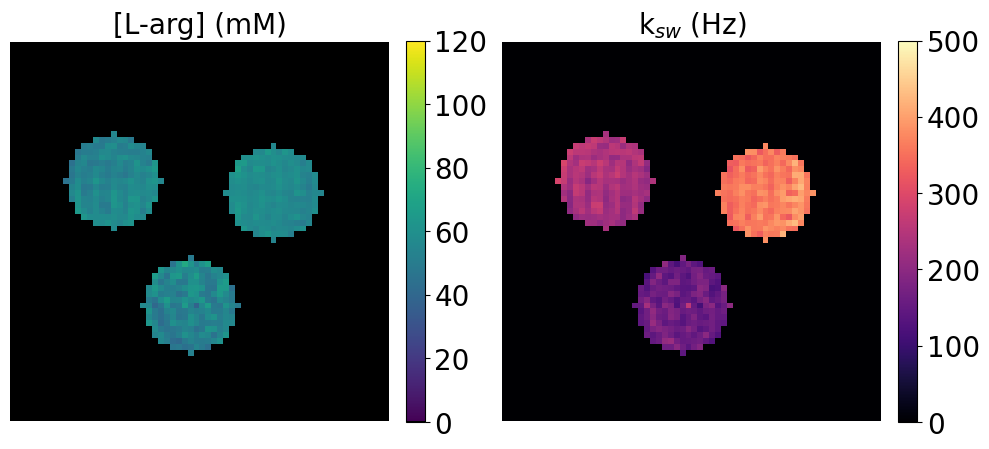

In [23]:
os.makedirs(output_f, exist_ok=True)

# Reshaping back to the image dimension
quant_map_fs = prediction.cpu().detach().numpy()[:, 0]
quant_map_fs = quant_map_fs.T
quant_map_fs = np.reshape(quant_map_fs, (c_acq_data, w_acq_data), order='F')

quant_map_ksw = prediction.cpu().detach().numpy()[:, 1]
quant_map_ksw = quant_map_ksw.T
quant_map_ksw = np.reshape(quant_map_ksw, (c_acq_data, w_acq_data), order='F')

quant_maps = {'fs': quant_map_fs, 'ksw': quant_map_ksw}

# Saving output maps
out_fn = 'nn_reco_maps_preclinical.mat'
out_fn = os.path.join(output_f, out_fn)
sio.savemat(out_fn, quant_maps)

# >>> Displaying output maps
pdf_fn = 'deep_reco_preclinical.pdf'
pdf_fn = os.path.join(output_f, pdf_fn)
pdf_handle = PdfPages(pdf_fn)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(quant_map_fs * 110e3 / 3 * mask, cmap=b_viridis, clim=(0, 120))
plt.title('[L-arg] (mM)', fontsize=20)
cb = plt.colorbar(ticks=np.arange(0.0, 120+20, 20), orientation='vertical', fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=20)
plt.axis("off")

plt.subplot(122)
plt.imshow(quant_map_ksw * mask, cmap='magma', clim=(0, 500))
cb = plt.colorbar(ticks=np.arange(0.0, 500+100, 100), orientation='vertical', fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=20)
plt.axis("off")
plt.title('k$_{sw}$ (Hz)', fontsize=20)

plt.tight_layout()
# plt.show() # for screen display
pdf_handle.savefig() # storing to pdf instead of display on screen

pdf_handle.close()
